<a href="https://colab.research.google.com/github/Mfiso1/Recurrent-Neural-Networks/blob/main/rnn_lstm_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os                           # Provides functions to interact with the operating system
import re                           # Allows regular expression operations for pattern matching and text cleaning
import numpy as np                  # Numerical computing library for arrays and mathematical operations
import pandas as pd                 # Data manipulation and analysis library (DataFrames, CSV/Excel I/O)
import nltk                         # Natural Language Toolkit for text processing and tokenization
from sklearn.model_selection import train_test_split   # Splits datasets into training and testing sets
from sklearn.preprocessing import LabelEncoder        # Converts categorical labels into numeric form
from tensorflow.keras.preprocessing.text import Tokenizer        # Converts text into sequences of integers for ML models
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Pads sequences to a fixed length for uniform input
from tensorflow.keras.utils import to_categorical               # Converts numeric labels into one-hot encoded vectors
from tensorflow.keras.models import Sequential                  # Keras class for building sequential neural network models
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout  # Layers: Embedding (word vectors), LSTM (sequence learning), Dense (fully connected), Dropout (regularization)


# Spark
from pyspark.sql import SparkSession          # Entry point for using Spark SQL and DataFrames in PySpark
from pyspark.sql.functions import input_file_name, udf  # input_file_name: gets the source file path; `udf` defines custom user functions
from pyspark.sql.types import StringType     # Defines the data type of columns when using UDFs or creating DataFrames -  in this instance -  string type

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
# Initializing Spark
spark = SparkSession.builder \
    .appName("AuthorPrediction") \
    .getOrCreate()


In [15]:
# Clone repo
!git clone https://github.com/Mfiso1/Recurrent-Neural-Networks.git
data_path = "Recurrent-Neural-Networks/text_files"  # folder name

# Read all .txt files into Spark DataFrame
df = spark.read.text(f"{data_path}/*.txt").withColumnRenamed("value", "text") \
    .withColumn("file_path", input_file_name())


fatal: destination path 'Recurrent-Neural-Networks' already exists and is not an empty directory.


In [16]:
df.show(5)   # Displays the first 5 rows in the DataFrame

+--------------------+--------------------+
|                text|           file_path|
+--------------------+--------------------+
|Project Gutenberg...|file:///content/R...|
|                    |file:///content/R...|
|This eBook is for...|file:///content/R...|
|no restrictions w...|file:///content/R...|
|under the terms o...|file:///content/R...|
+--------------------+--------------------+
only showing top 5 rows



In [17]:
# Show all unique file paths
df.select("file_path").distinct().show(truncate=False)


+----------------------------------------------------------------------------------------------------------------+
|file_path                                                                                                       |
+----------------------------------------------------------------------------------------------------------------+
|file:///content/Recurrent-Neural-Networks/text_files/Emma_by_Jane_Austen.txt                                    |
|file:///content/Recurrent-Neural-Networks/text_files/A_Tale_of_Two_Cities_by_Charles_Dickens.txt                |
|file:///content/Recurrent-Neural-Networks/text_files/Great_Expectations_by_Charles_Dickens.txt                  |
|file:///content/Recurrent-Neural-Networks/text_files/The_Adventures_of_Sherlock_Holmes_by_Arthur_Conan_Doyle.txt|
|file:///content/Recurrent-Neural-Networks/text_files/Ulysses_by_James_Joyce.txt                                 |
|file:///content/Recurrent-Neural-Networks/text_files/Adventures_of_Huckleberry_

In [18]:
# Extract author from filename
def extract_author(path):
    return re.findall(r'_by_(.*).txt', path)[0]

author_udf = udf(extract_author, StringType())
df = df.withColumn("author", author_udf("file_path"))

# Optional: clean text, remove punctuation
def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text.lower())

clean_udf = udf(clean_text, StringType())
df = df.withColumn("clean_text", clean_udf("text"))

df.show(5)


+--------------------+--------------------+---------------+--------------------+
|                text|           file_path|         author|          clean_text|
+--------------------+--------------------+---------------+--------------------+
|Project Gutenberg...|file:///content/R...|Alexandre_Dumas|project gutenberg...|
|                    |file:///content/R...|Alexandre_Dumas|                    |
|This eBook is for...|file:///content/R...|Alexandre_Dumas|this ebook is for...|
|no restrictions w...|file:///content/R...|Alexandre_Dumas|no restrictions w...|
|under the terms o...|file:///content/R...|Alexandre_Dumas|under the terms o...|
+--------------------+--------------------+---------------+--------------------+
only showing top 5 rows



In [19]:
# Show all unique authors
df.select("author").distinct().show(truncate=False)

+------------------------+
|author                  |
+------------------------+
|Arthur_Conan_Doyle      |
|Charles_Dickens         |
|Alexandre_Dumas         |
|Jane_Austen             |
|Mark_Twain              |
|Anonymous               |
|James_Joyce             |
|Bram_Stoker             |
|Oscar_Wilde             |
|Charlotte_Perkins_Gilman|
|Franz_Kafka             |
|Lewis_Carroll           |
|Henrik_Ibsen            |
|Nicolo_Machiavelli      |
|Mary_Shelley            |
|The_Brothers_Grimm      |
+------------------------+



In [20]:
pandas_df = df.select("clean_text", "author").toPandas()
texts = pandas_df['clean_text'].tolist()
labels = pandas_df['author'].tolist()


In [21]:
# Count the total number of rows in the DataFrame
record_count = df.count()
print("Total records:", record_count)


Total records: 274722


In [22]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=500, padding='post')

le = LabelEncoder()
y = to_categorical(le.fit_transform(labels))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=500),
    LSTM(128),
    Dropout(0.2),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
6182/6182 ━━━━━━━━━━━━━━━━━━━━ 3256s 526ms/step - accuracy: 0.2225 - loss: 2.4146 - val_accuracy: 0.2208 - val_loss: 2.4066
Epoch 2/5
6182/6182 ━━━━━━━━━━━━━━━━━━━━ 3391s 547ms/step - accuracy: 0.2238 - loss: 2.4009 - val_accuracy: 0.2208 - val_loss: 2.4075
Epoch 3/5
6182/6182 ━━━━━━━━━━━━━━━━━━━━ 3413s 543ms/step - accuracy: 0.2235 - loss: 2.4037 - val_accuracy: 0.2208 - val_loss: 2.4064
Epoch 4/5
6182/6182 ━━━━━━━━━━━━━━━━━━━━ 3421s 549ms/step - accuracy: 0.2223 - loss: 2.4075 - val_accuracy: 0.2208 - val_loss: 2.4062
Epoch 5/5
6182/6182 ━━━━━━━━━━━━━━━━━━━━ 3286s 524ms/step - accuracy: 0.2240 - loss: 2.4035 - val_accuracy: 0.2208 - val_loss: 2.4062


In [24]:
# Save the model in HDF5 format
model.save("author_prediction_model.h5")


In [26]:
print("Total records:", df.count())
print("Number of distinct files:", df.select("file_path").distinct().count())
print("Number of distinct authors:", df.select("author").distinct().count())


Total records: 274722
Number of distinct files: 20
Number of distinct authors: 16


In [28]:
df.groupBy("author").count().show()


+--------------------+-----+
|              author|count|
+--------------------+-----+
|  Arthur_Conan_Doyle|13052|
|     Charles_Dickens|36694|
|     Alexandre_Dumas|61162|
|         Jane_Austen|30060|
|          Mark_Twain|20401|
|           Anonymous|18458|
|         James_Joyce|32576|
|         Bram_Stoker|15973|
|         Oscar_Wilde|12399|
|Charlotte_Perkins...| 1238|
|         Franz_Kafka| 2362|
|       Lewis_Carroll| 3736|
|        Henrik_Ibsen| 4324|
|  Nicolo_Machiavelli| 5063|
|        Mary_Shelley| 7653|
|  The_Brothers_Grimm| 9571|
+--------------------+-----+



In [29]:
from pyspark.sql.functions import length, avg

df.withColumn("text_length", length("text")) \
  .groupBy("author").agg(avg("text_length").alias("avg_length")) \
  .show()


+--------------------+------------------+
|              author|        avg_length|
+--------------------+------------------+
|  Arthur_Conan_Doyle| 43.58037082439473|
|     Charles_Dickens| 47.78590505259716|
|     Alexandre_Dumas|42.226970995062295|
|         Jane_Austen|  52.4457751164338|
|          Mark_Twain|45.490907308465275|
|           Anonymous| 55.94804420847329|
|         James_Joyce| 46.09838531434185|
|         Bram_Stoker|   53.287860765041|
|         Oscar_Wilde| 46.75014114041455|
|Charlotte_Perkins...|40.066235864297255|
|         Franz_Kafka|57.871718882303135|
|       Lewis_Carroll| 42.84796573875803|
|        Henrik_Ibsen|  36.2895467160037|
|  Nicolo_Machiavelli| 58.40825597471854|
|        Mary_Shelley| 56.62877303018424|
|  The_Brothers_Grimm|55.445512485633685|
+--------------------+------------------+



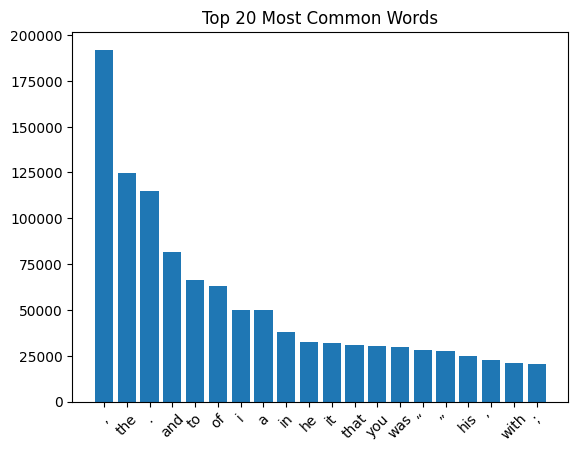

In [34]:
import matplotlib.pyplot as plt

common_words = dict(word_freq.most_common(20))
plt.bar(common_words.keys(), common_words.values())
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words")
plt.show()


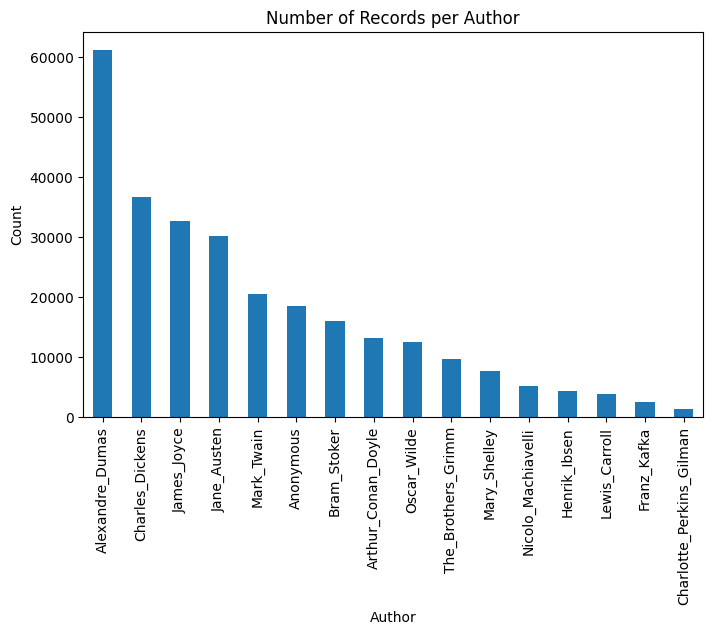

In [35]:
import matplotlib.pyplot as plt

df_pd['author'].value_counts().plot(kind='bar', figsize=(8,5))
plt.title("Number of Records per Author")
plt.xlabel("Author")
plt.ylabel("Count")
plt.show()


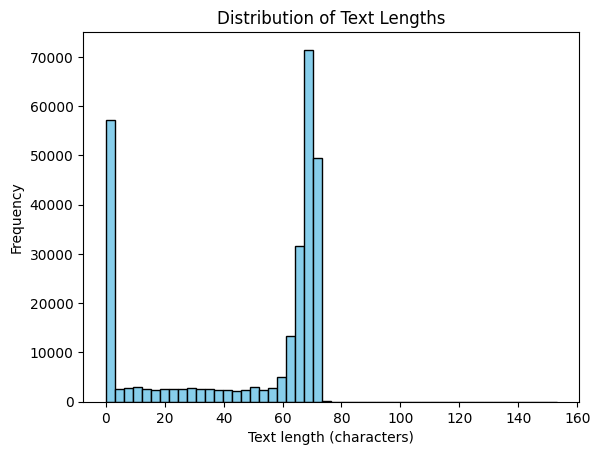

In [36]:
df_pd['text_length'] = df_pd['text'].apply(len)

plt.hist(df_pd['text_length'], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Text Lengths")
plt.xlabel("Text length (characters)")
plt.ylabel("Frequency")
plt.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


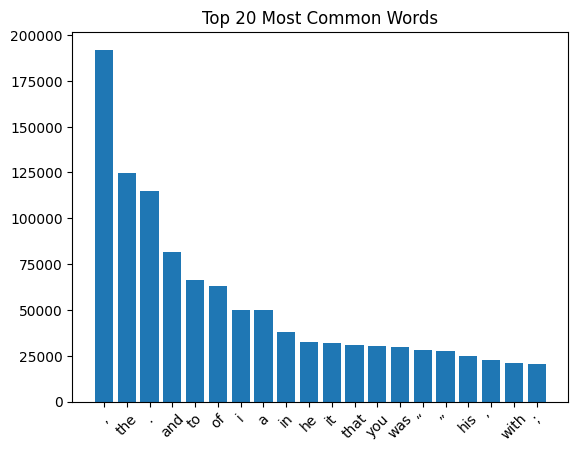

In [37]:
from collections import Counter
import nltk
nltk.download("punkt")

all_words = []
for txt in df_pd["text"]:
    all_words.extend(nltk.word_tokenize(txt.lower()))

word_freq = Counter(all_words)
common_words = dict(word_freq.most_common(20))

plt.bar(common_words.keys(), common_words.values())
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words")
plt.show()


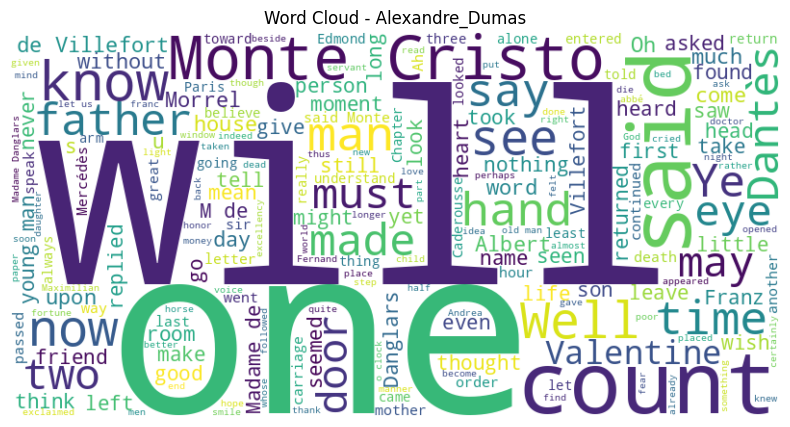

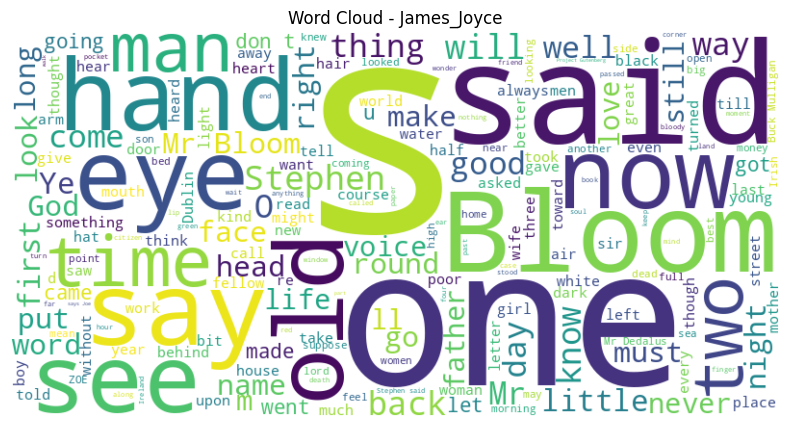

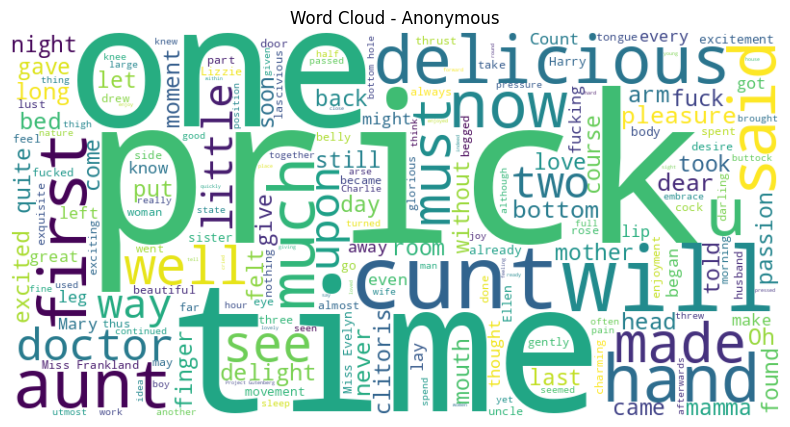

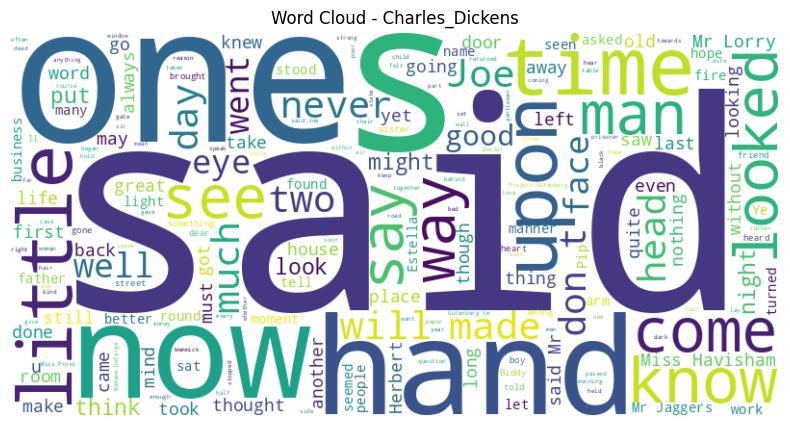

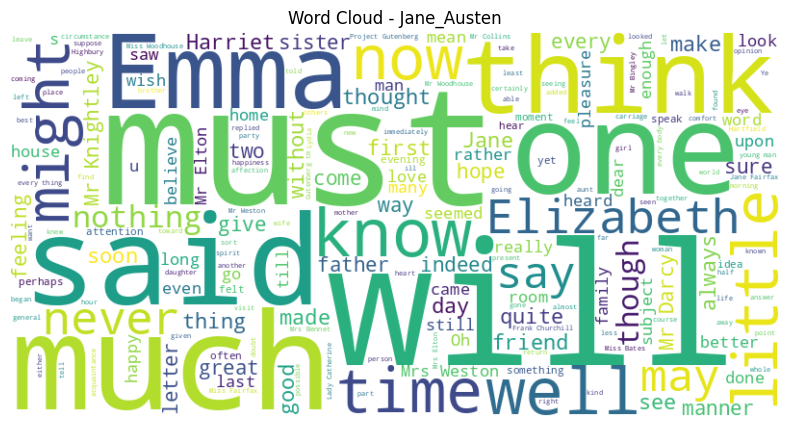

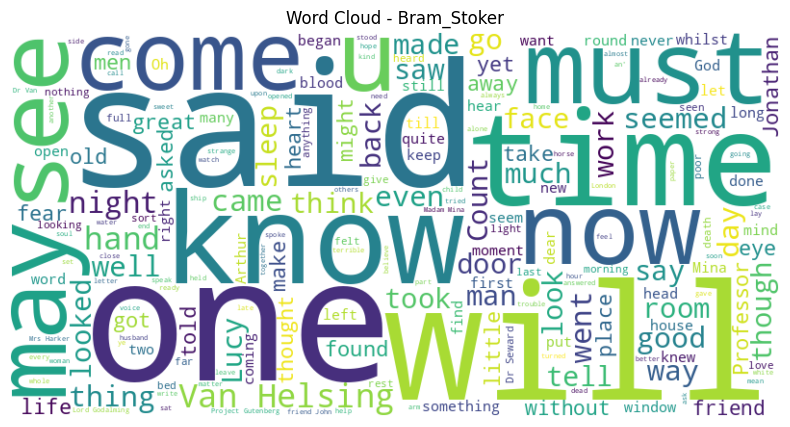

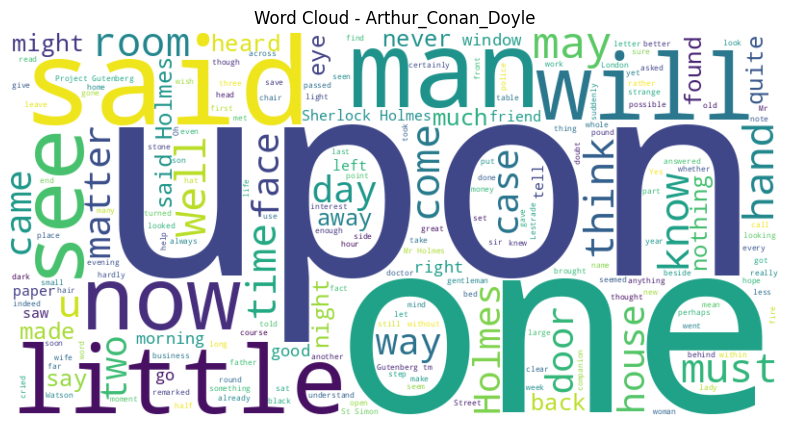

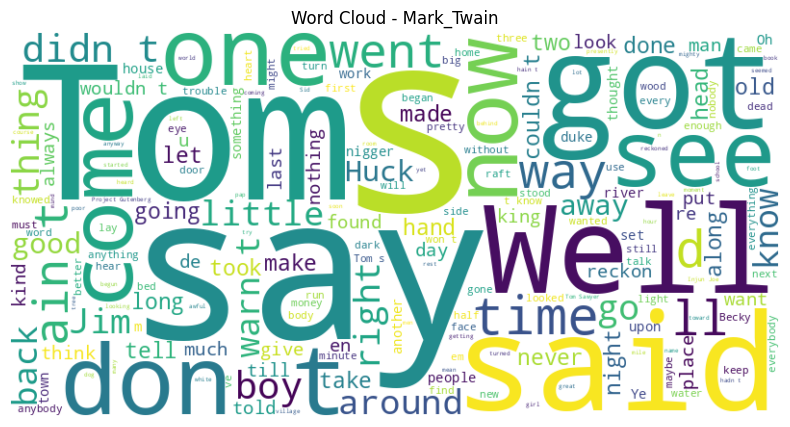

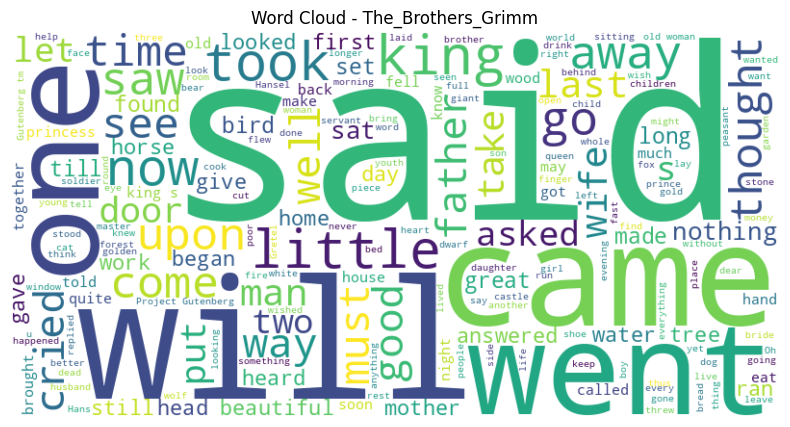

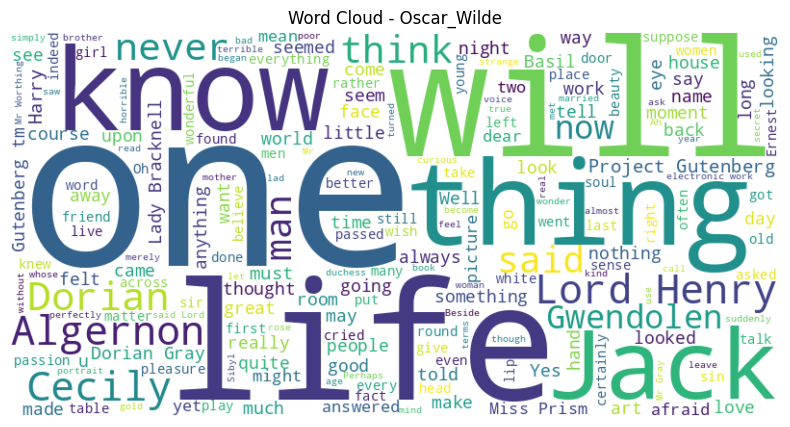

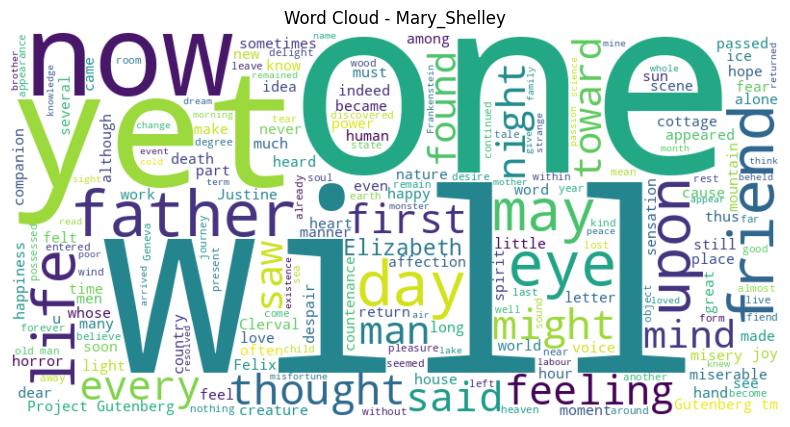

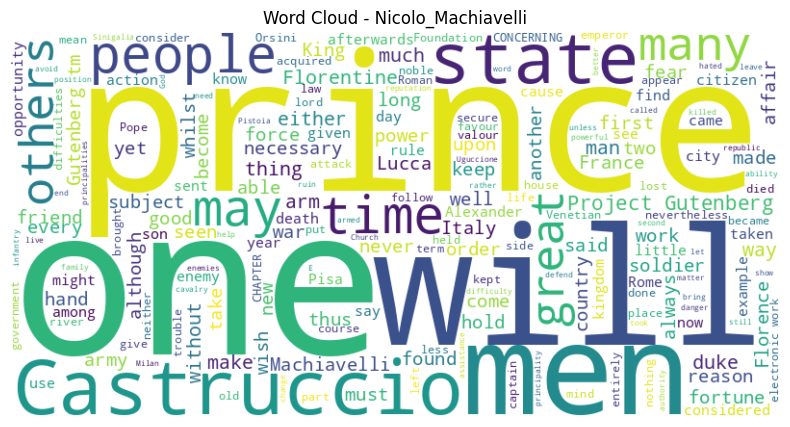

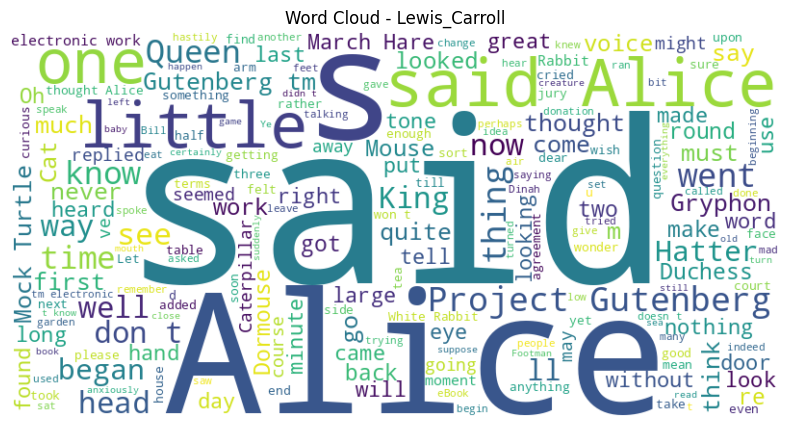

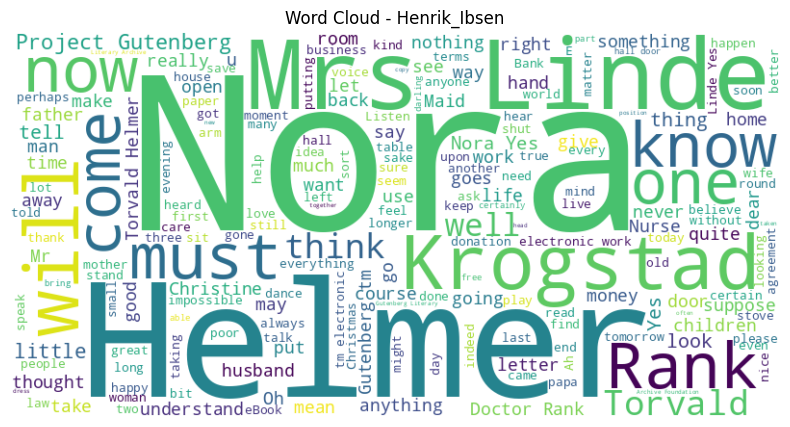

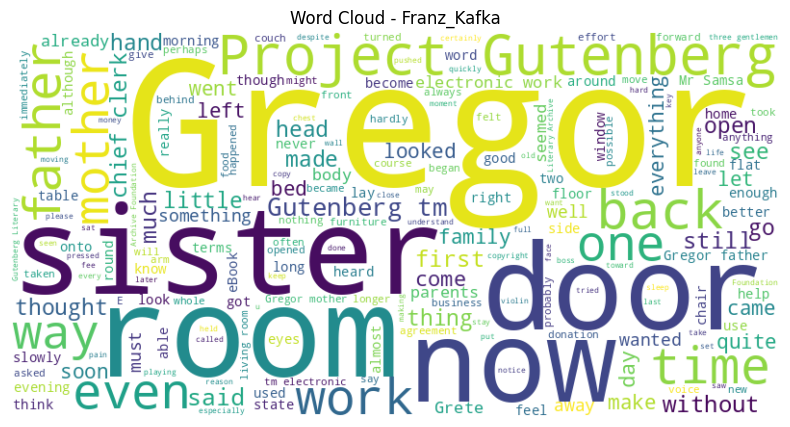

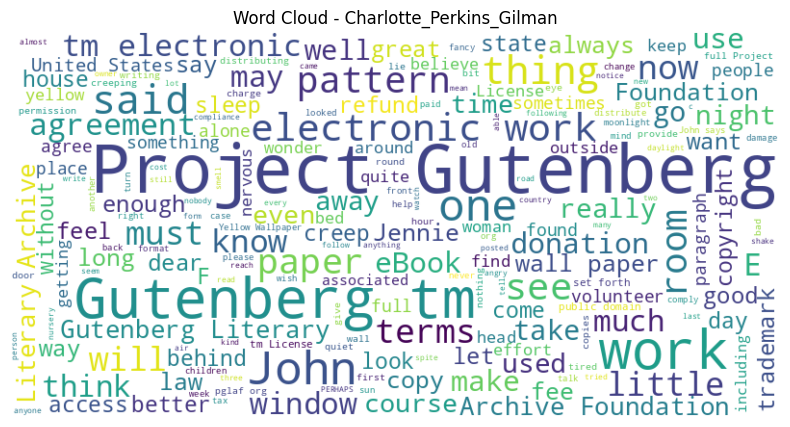

In [38]:
from wordcloud import WordCloud

for author in df_pd['author'].unique():
    text = " ".join(df_pd[df_pd['author'] == author]['text'])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {author}")
    plt.show()


In [33]:
# Convert Spark DataFrame to Pandas for local analysis
df_pd = df.toPandas()

# Tokenize text
from collections import Counter
import nltk
nltk.download("punkt")

all_words = []
for txt in df_pd["text"]:
    all_words.extend(nltk.word_tokenize(txt.lower()))

word_freq = Counter(all_words)
print(word_freq.most_common(20))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[(',', 192104), ('the', 124533), ('.', 114929), ('and', 81511), ('to', 66239), ('of', 63045), ('i', 49982), ('a', 49735), ('in', 37809), ('he', 32676), ('it', 31831), ('that', 31069), ('you', 30342), ('was', 29776), ('“', 28127), ('”', 27363), ('his', 24592), ('’', 22550), ('with', 20923), (';', 20551)]


In [32]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [27]:
df.select("author", "text").show(10, truncate=100)


+---------------+-----------------------------------------------------------------------+
|         author|                                                                   text|
+---------------+-----------------------------------------------------------------------+
|Alexandre_Dumas|Project Gutenberg's The Count of Monte Cristo, by Alexandre Dumas, père|
|Alexandre_Dumas|                                                                       |
|Alexandre_Dumas|This eBook is for the use of anyone anywhere at no cost and with almost|
|Alexandre_Dumas|no restrictions whatsoever.  You may copy it, give it away or re-use it|
|Alexandre_Dumas|    under the terms of the Project Gutenberg License included with this|
|Alexandre_Dumas|                                   eBook or online at www.gutenberg.org|
|Alexandre_Dumas|                                                                       |
|Alexandre_Dumas|                                                                       |
|Alexandre